## Importamos librerías y dataset

In [1]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# 1) Describimos el dataset

In [3]:
print('Train set size:  ', X_train.shape)
print('Test set size:   ', X_test.shape)

Train set size:   (60000, 28, 28)
Test set size:    (10000, 28, 28)


In [97]:
print('datatypes: ', X_train.dtype, X_test.dtype)

datatypes:  float32 float32


Graficamos, iterando con la ayuda del amigo chat gpt

/var/folders/w2/38zz5scj7lq_rpnmpknfg8mh0000gn/T/ipykernel_2749/3844854881.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Labels', y='Values', data=data, palette='viridis')


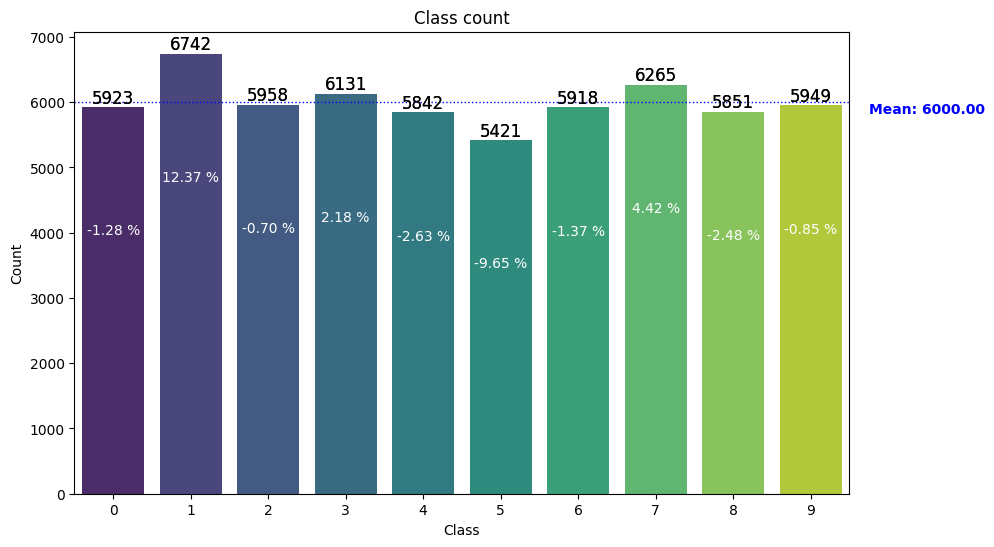

Etiquetas del Dataset: [0 1 2 3 4 5 6 7 8 9]
Cantidad de elementos por etiqueta: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
Cantidad promedio por etiqueta: 6000.0
Desviaciones estándar de la media: [-1.283, 12.367, -0.7, 2.183, -2.633, -9.65, -1.367, 4.417, -2.483, -0.85]


In [4]:
labels, values = np.unique(y_train, return_counts = True)

data = pd.DataFrame({'Labels': labels, 'Values': values})

plt.figure(figsize=(10, 6)) 
sns.barplot(x='Labels', y='Values', data=data, palette='viridis')

# Add labels to each bar
for index, value in enumerate(values):
    plt.text(index, value + 0.5,  # x and y coordinates
             f'{value}',          # The label text
             ha='center',         # Horizontal alignment
             va='bottom',         # Vertical alignment
             fontsize=12,         # Font size
             color='black')       # Font color

# Calculate the mean of the values
mean_value = sum(values) / len(values)

# Calculate the standard deviation of the values
std_dev = np.std(values, ddof=1)  # Using Bessel's correction (ddof=1)

# Calculate the absolute deviation from the mean for each value
#deviations = [np.std(values) for value in values]
deviations = [np.round(((value - mean_value) / mean_value) * 100, 3) for value in values]

# Add labels to each bar
for index, (value, deviation) in enumerate(zip(values, deviations)):
    plt.text(index, value + 0.5,  # x and y coordinates for the value label
             f'{value}',          # The value label text
             ha='center',         # Horizontal alignment
             va='bottom',         # Vertical alignment
             fontsize=12,         # Font size
             color='black')       # Font color
    
    # Add the deviation from the mean
    plt.text(index, value - 2000,  # x and y coordinates for the deviation label, slightly below the bar
             f'{deviation:.2f} %',  # The deviation label text
             ha='center',          # Horizontal alignment
             va='bottom',          # Vertical alignment
             fontsize=10,          # Font size
             color='white')         # Font color
    
# Add a horizontal line for the mean value
plt.axhline(mean_value, color='blue', linestyle='dotted', linewidth=1, label=f'Mean Value ({mean_value:.2f})')

# Annotate the mean line
plt.text(len(labels)+0.5, mean_value + 0.5,  # Position of the annotation
         f'Mean: {mean_value:.2f}',          # The text of the annotation
         color='blue',                        # Text color
         ha='center',                        # Horizontal alignment
         va='top',                        # Vertical alignment
         fontsize=10,                        # Font size
         weight='bold')                      # Font weight
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class count')


plt.show()

print(f'Etiquetas del Dataset: {labels}')
print(f'Cantidad de elementos por etiqueta: {values}')
print(f'Cantidad promedio por etiqueta: {mean_value}')
print(f'Desviaciones estándar de la media: {deviations}')

El dataset parece bastante bien balanceado (es esperable, es MNIST!)

### mostramos una imagen de cada digito:

In [5]:
# Buscamos el primer representante de cada clase, es decir el primer index de cada etiqueta en y_train
class_representative_indexes = {}
y_train_df = pd.DataFrame({'Label':y_train})
for label in labels:
    class_representative_indexes[label] = y_train_df[y_train_df.Label == label].index[0]
class_representative_indexes

{0: 1, 1: 3, 2: 5, 3: 7, 4: 2, 5: 0, 6: 13, 7: 15, 8: 17, 9: 4}

La posición de la imagen a mostrar es la 1
La etiqueta de la imagen es: 0


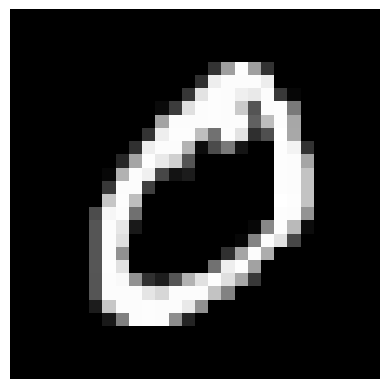

La posición de la imagen a mostrar es la 3
La etiqueta de la imagen es: 1


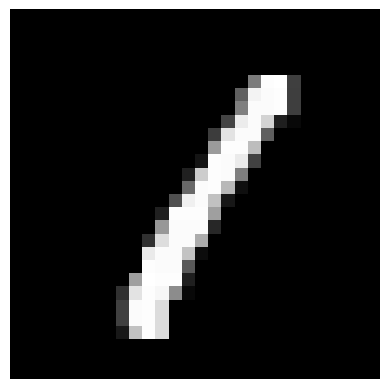

La posición de la imagen a mostrar es la 5
La etiqueta de la imagen es: 2


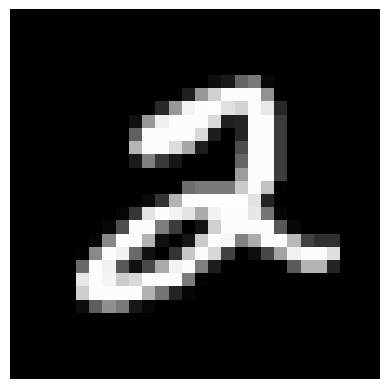

La posición de la imagen a mostrar es la 7
La etiqueta de la imagen es: 3


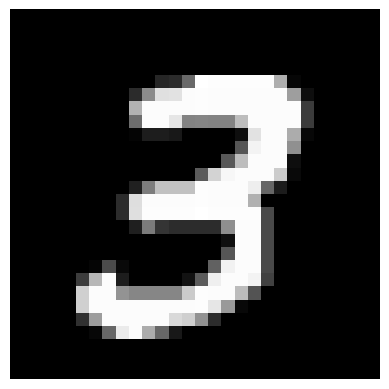

La posición de la imagen a mostrar es la 2
La etiqueta de la imagen es: 4


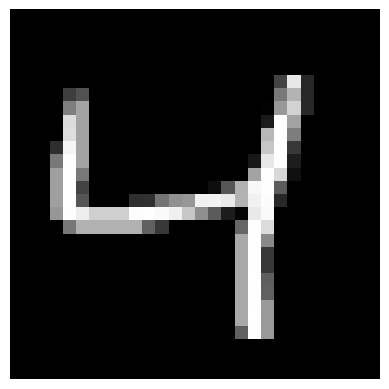

La posición de la imagen a mostrar es la 0
La etiqueta de la imagen es: 5


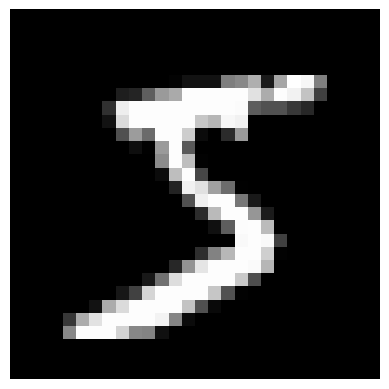

La posición de la imagen a mostrar es la 13
La etiqueta de la imagen es: 6


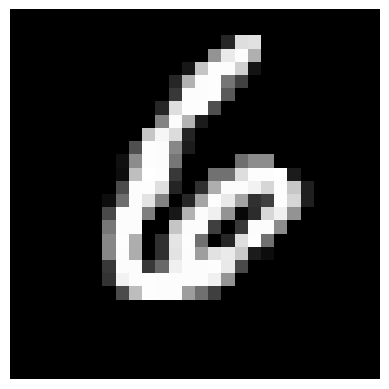

La posición de la imagen a mostrar es la 15
La etiqueta de la imagen es: 7


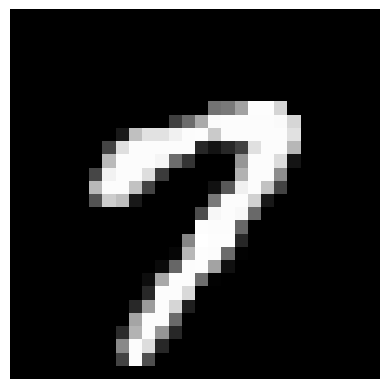

La posición de la imagen a mostrar es la 17
La etiqueta de la imagen es: 8


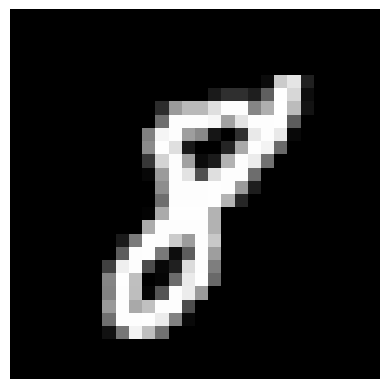

La posición de la imagen a mostrar es la 4
La etiqueta de la imagen es: 9


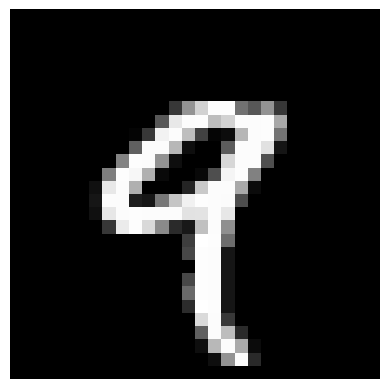

In [6]:
for i in class_representative_indexes.values():
    print(f'La posición de la imagen a mostrar es la {i}')
    print(f'La etiqueta de la imagen es: {y_train[i]}')
    plt.imshow(X_train[i, :, :], cmap = 'gray')
    plt.axis('off')
    plt.show()

## 2) Segmentación del dataset
simplemente usaremos la que viene como defecto en el dataset

# 3 y 4) Modelos y Métricas
### 3.1 Random Forest

In [7]:
#Importamos el clasificador y las métricas

from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)


Transformamos los datasets en Data Frames, enviando al indíce el indice de cada imagen y a las columnas, cada uno de los 24x24 pixeles, de nuevo nos ayuda chat gpt:

In [8]:

# Function to transform an array of images into a DataFrame
def images_to_dataframe(images, dataset_type):
    # Flatten the images
    images_flattened = images.reshape(images.shape[0], -1)
    # Create column names
    pixel_columns = [f'pixel{i}' for i in range(images_flattened.shape[1])]
    # Create DataFrame
    df = pd.DataFrame(images_flattened, columns=pixel_columns)
    # Set the index name
    df.index.name = f'{dataset_type}_image_index'
    return df

# Transform X_train
X_train_df = images_to_dataframe(X_train, 'train')
# Transform X_test
X_test_df = images_to_dataframe(X_test, 'test')

# Transform y_train into a DataFrame
y_train_df = pd.DataFrame(y_train, columns=['label'])
y_train_df.index.name = 'train_image_index'

# Transform y_test into a DataFrame
y_test_df = pd.DataFrame(y_test, columns=['label'])
y_test_df.index.name = 'test_image_index'

In [9]:
#Entrenamos un Árbol de desición y predecimos:
rf = RandomForestClassifier(random_state=12, n_estimators=20,
                               class_weight="balanced", max_features="log2") #Elegimos random_state=12 porque soy hincha de Boca.
rf.fit(X_train_df, y_train)

y_pred=rf.predict(X_test_df)
proba_pred_test=rf.predict_proba(X_test_df)
print('Predicciones RF: ', y_pred)
print('Verdaderos:', y_test)

print(f"RF Accuracy: {rf.score(X_test_df, y_test)}")

Predicciones RF:  [7 2 1 ... 4 5 6]
Verdaderos: [7 2 1 ... 4 5 6]
RF Accuracy: 0.9537


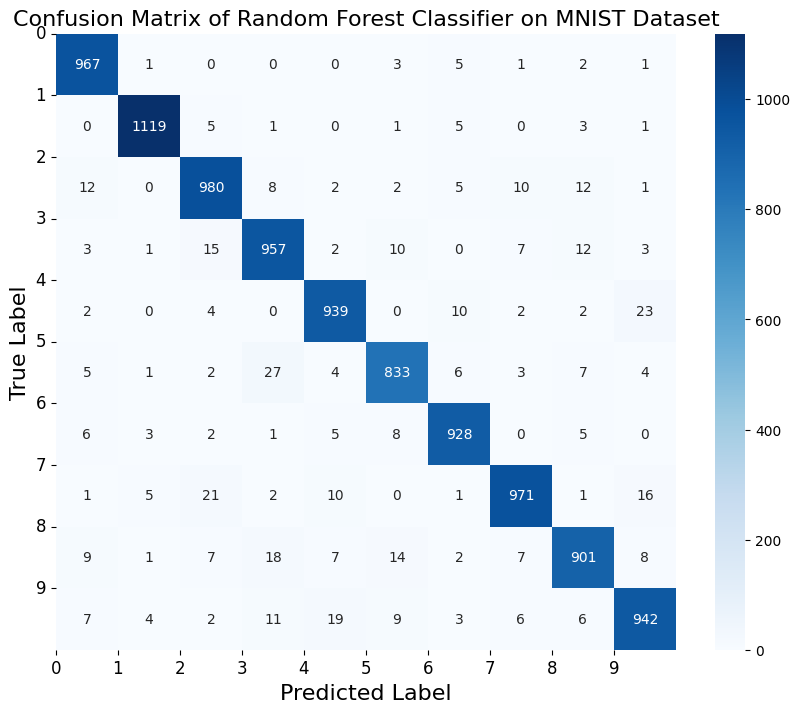

In [10]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
#sns.heatmap(conf_matrix, annot=conf_matrix.rank(axis="columns"), fmt='d', xticklabels=range(10), yticklabels=range(10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label', fontsize=16)
plt.ylabel('True Label', fontsize=16)
plt.title('Confusion Matrix of Random Forest Classifier on MNIST Dataset', fontsize=16)
plt.xticks(ticks=np.arange(10), labels=[f'{i}' for i in range(10)], fontsize=12)
plt.yticks(ticks=np.arange(10), labels=[f'{i}' for i in range(10)], fontsize=12, rotation=0)
plt.show()

Le fue MUY bien al random forest. En caso de tener clases desbalanceadas, deberiamos usar una media armónica (el F1) como métrica, pero teniendo clases tan bien balanceadas, el accuracy es una métrica razonable, nos basta que el modelo le "pegue" seguido para concluir que es bueno. Esto no es así en dataset desbalanceados: Si tuviesemos una clase que representase el 90% del dataset, un clasificador naive que siempre devuelva la etiqueta de esa clase tendría una accuracy del 90% y sería pésimo.

## 3.2 CNN
Simplemente copiamos el código de la Notebook 13 con algunos cambios

In [63]:
y_train_CNN = keras.utils.to_categorical(y_train)
y_test_CNN = keras.utils.to_categorical(y_test)

## Definición por capas

## Capa de Entrada

In [75]:
Imagen_de_entrada = layers.Input(shape = (28, 28, 1)) # Le damos la forma de nuestras imágenes.

## Capa de Convolución

In [76]:
X = layers.Conv2D(filters = 12, kernel_size = (3, 3), activation = None)(Imagen_de_entrada)

## Capa de Normalización

In [77]:
X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

## Capa de Max - Pooling

In [78]:
X = layers.MaxPooling2D(pool_size = (2, 2))(X)

In [79]:
X = layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = None)(X)

X = layers.BatchNormalization()(X)

X = layers.Activation("relu")(X)

Flatten = layers.Flatten()(X)

Notar que acá pasamos a las capas totalmente conectadas:

In [80]:
X = layers.Dense(256, activation = "sigmoid")(Flatten)

X = layers.Dense(64, activation = "sigmoid")(X)

Salida = layers.Dense(units = 10, activation = 'softmax')(Flatten)

Definimos la red:

In [81]:
Red_Neuronal = keras.Model(inputs = Imagen_de_entrada, outputs = Salida)

Red_Neuronal.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

Observamos el número de parámetros por capa:

In [98]:
Red_Neuronal.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 26, 26, 12)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 26, 26, 12)     │            48 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 26, 26, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 13, 13, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 11, 11, 64)     │         6,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 11, 11, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 7744)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 10)             │        77,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 254,248 (993.16 KB)

 Trainable params: 84,698 (330.85 KB)

 Non-trainable params: 152 (608.00 B)

 Optimizer params: 169,398 (661.71 KB)

84.698 parametros entrenables!

### Entrenamos la Red

In [82]:
Historia = Red_Neuronal.fit(x = X_train, y = y_train, epochs = 9, batch_size = 32, validation_data = (X_test, y_test))

Epoch 1/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9298 - loss: 0.2373 - val_accuracy: 0.9812 - val_loss: 0.0632
Epoch 2/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9843 - loss: 0.0524 - val_accuracy: 0.9869 - val_loss: 0.0407
Epoch 3/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9895 - loss: 0.0310 - val_accuracy: 0.9852 - val_loss: 0.0474
Epoch 4/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9933 - loss: 0.0212 - val_accuracy: 0.9878 - val_loss: 0.0367
Epoch 5/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9942 - loss: 0.0178 - val_accuracy: 0.9875 - val_loss: 0.0433
Epoch 6/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.9962 - loss: 0.0120 - val_accuracy: 0.9868 - val_loss: 0.0477
Epoch 7/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9967 - loss: 0.0093 - val_accuracy: 0.9881 - val_loss: 0.0397
Epoch 8/9
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9971 - loss: 0.0085 - 

### Visualizamos la accuracy por epoch:

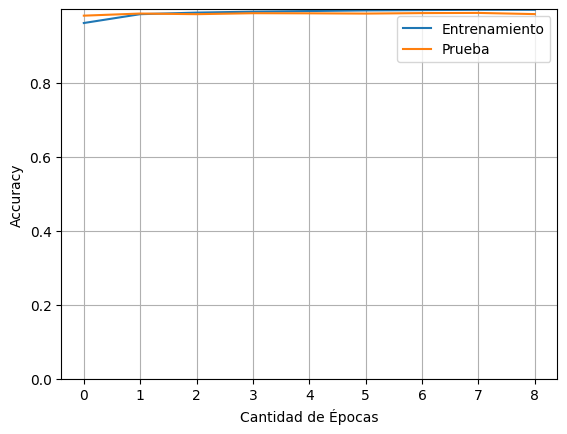

In [83]:
plt.plot(Historia.history['accuracy'], label = 'Entrenamiento')
plt.plot(Historia.history['val_accuracy'], label = 'Prueba')
plt.grid()
plt.ylim(bottom=0)
plt.xlabel('Cantidad de Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Vemos la matriz de confusión de la CNN:

<Figure size 1000x800 with 0 Axes>

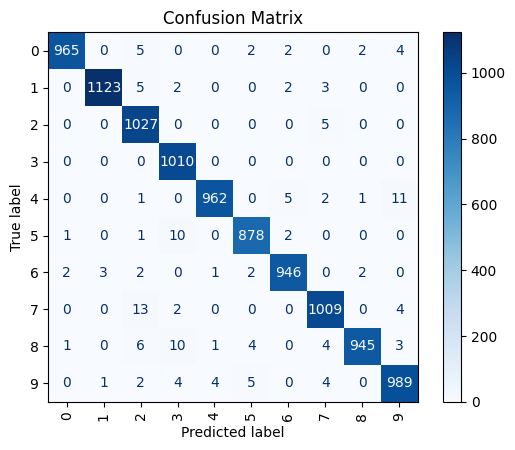

In [92]:
Y_pred = Red_Neuronal.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1) 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test, axis=1) 

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

Y podemos concluir que es mejor que el random forest. Ahora, es mucho mejor? Para un modelo tanto más pesado de entrenar? <br>
Hay mucho que se puede refinar tuneando hiperparametros

# Clasificación vs Regresión
Aquí entrenamos un modelo para que clasifique imágenes usando las 10 etiquetas posibles, en vez de pedirle que que le asigne un valor numérico con orden (el valor numérico lo asigna pero es discreto y sin orden, no es más grande la etiqueta del 1 que la del 2, por mas que como números lo sean, son simplemente categorías distintas como "gato" y "tractor"). <br>

La diferencia la encontramos también en las métricas que hemos definido: Accuracy es una métrica de clasificación por definición. Si hubiesemos minimizado el MSE, estaríamos en un problema de regresión. En la clasificación, segmentamos por grupos, en la regresión, encontramos un valor continuo (y dentro de una estructura ordenada) que le asigna una función --mas bien, lo que encontramos es la función y la evaluamos en el datapoint--, como por ejemplo podría ser la temperatura de un punto dentro de una casa en función de las coordenadas tridimensionales del punto o el precio de una casa en base a sus características.

# Bonus Track
otra CNN con algunos cambios que logra una mejor accuracy:

Epoch 1/10


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - accuracy: 0.7382 - loss: 0.7974 - val_accuracy: 0.9747 - val_loss: 0.0877
Epoch 2/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.9569 - loss: 0.1424 - val_accuracy: 0.9803 - val_loss: 0.0664
Epoch 3/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9697 - loss: 0.0987 - val_accuracy: 0.9872 - val_loss: 0.0457
Epoch 4/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9754 - loss: 0.0824 - val_accuracy: 0.9872 - val_loss: 0.0453
Epoch 5/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9794 - loss: 0.0714 - val_accuracy: 0.9872 - val_loss: 0.0409
Epoch 6/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9807 - loss: 0.0630 - val_accuracy: 0.9889 - val_loss: 0.0352
Epoch 7/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9818 - loss: 0.0576 - val_accuracy: 0.9895 - val_loss: 0.0346
Epoch 8/10
375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.9835 - loss: 0.0561 - val_accuracy: 0.989

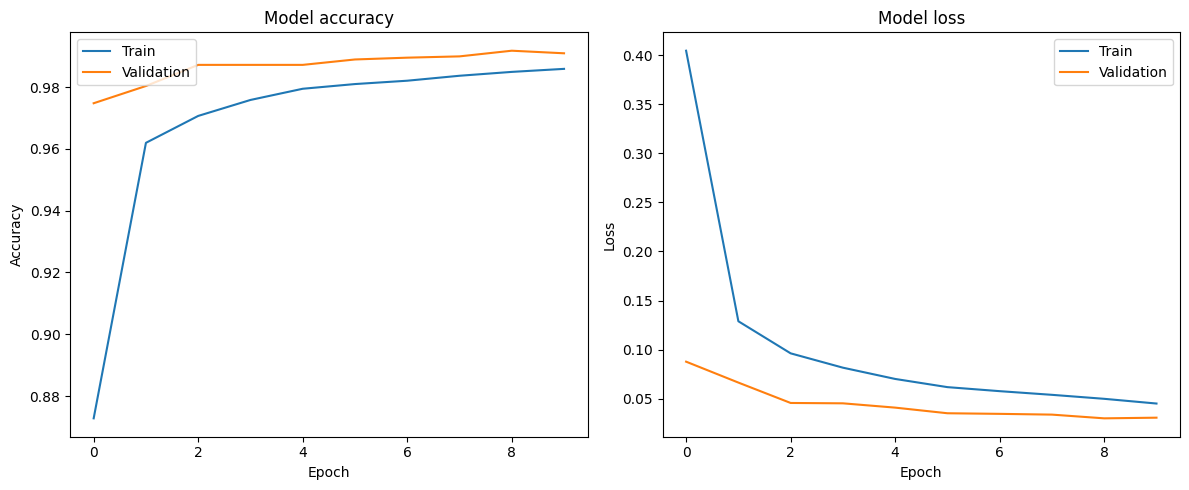

In [21]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize the pixel values to the range [0, 1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape the data to include the channel dimension
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Define the CNN architecture
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=10, 
                    validation_split=0.2, 
                    verbose=1)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f'Test accuracy: {test_accuracy:.2f}')

# Plot the training history
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


Notemos que su val_accuracy es mejor que que la accuracy de train. Esto es, parece que justo para lo que dejamos de validation set, esta red generaliza mejor que lo que muestra a nivel entrenamiento. Obviamente, habría que probar con más datos a ver si esta tendencia se mantiene. <br>

Hacemos acá también una confusion matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 1000x800 with 0 Axes>

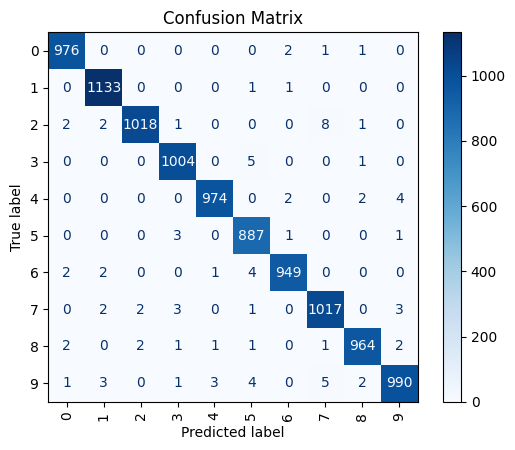

In [94]:
Y_pred_2 = model.predict(X_test)
Y_pred_2 = np.argmax(Y_pred_2, axis=1) 

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = np.argmax(y_test, axis=1) 

cm = confusion_matrix(y_true, Y_pred_2)

plt.figure(figsize=(10, 8))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_true))
cm_display.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()